In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
import pytz
import re

# 1. Function to convert epoch to a CST datetime object
def convert_epoch_to_cst_datetime(epoch, cst):
    utc_time = datetime.utcfromtimestamp(epoch).replace(tzinfo=pytz.utc)
    return utc_time.astimezone(cst)

# 2. Function to create 'submitInterval' column based on time of day
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# 3. Function to read CSV file
def read_csv(file_path):
    return pd.read_csv(file_path)

# 4. Function to convert 'submitTime', 'startTime', and 'endTime' to CST
def convert_time_columns(df, cst):
    df['submitTime'] = df['submitTime'].apply(lambda x: convert_epoch_to_cst_datetime(x, cst))
    df['startTime'] = df['startTime'].apply(lambda x: convert_epoch_to_cst_datetime(x, cst))
    df['endTime'] = df['endTime'].apply(lambda x: convert_epoch_to_cst_datetime(x, cst))
    return df

# 5. Function to calculate 'pendTime'
def calculate_pend_time(df):
    df['pendTime'] = (df['startTime'] - df['submitTime']).dt.total_seconds()
    return df

# 6. Function to add 'submitInterval' and 'submitDay' columns
def add_time_of_day_and_day(df):
# Define the desired order for submitDay and submitInterval
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    interval_order = ['Morning', 'Afternoon', 'Evening', 'Night']
    
    # Add submitInterval and submitDay columns
    df['submitInterval'] = df['submitTime'].dt.hour.apply(get_time_of_day)
    df['submitDay'] = df['submitTime'].dt.day_name()
    
    # Set categorical ordering for submitDay and submitInterval
    df['submitDay'] = pd.Categorical(df['submitDay'], categories=day_order, ordered=True)
    df['submitInterval'] = pd.Categorical(df['submitInterval'], categories=interval_order, ordered=True)

    return df

# 7. Function to overwrite 'queue' after replacing 'rhel8_' and 'rhel88_'
def overwrite_queue(df):
    df['queue'] = df['queue'].str.replace(r'rhel8_', '', regex=True)
    df['queue'] = df['queue'].str.replace(r'rhel88_', '', regex=True)
    return df

# 8. Function to extract memory from 'resReq' and overwrite existing values
def extract_requested_memory(df):
    df['resReq'] = df['resReq'].astype(str)
    df['requested_memory'] = df['resReq'].apply(lambda resReq: float(re.search(r'mem=(\d+(\.\d+)?)', resReq).group(1)) if re.search(r'mem=(\d+(\.\d+)?)', resReq) else None)
    return df.dropna(subset=['requested_memory'])

# 9. Function to convert 'maxRMem' from KB to MB
def convert_max_rmem(df):
    df['maxRMem'] = df['maxRMem'] / 1024
    return df

# 10. Function to create the 'userCancelJob' indicator variable
def create_user_cancel_job(df):
    df['userCancelJob'] = np.where(df['pendTime'] < 0, 1, 0)
    return df

# 11. Function to filter rows where 'userCancelJob' is greater than 0
def remove_user_cancel_job(df):
    return df[df['userCancelJob'] == 0]

# 12. Function to order the 'queue' variable based on value counts
def order_queue_by_value_counts(df):
    queue_counts = df['queue'].value_counts()
    ordered_queues = queue_counts.index
    df['queue'] = pd.Categorical(df['queue'], categories=ordered_queues, ordered=True)
    return df

#13. Define Job category based on Job distribution
def define_job_category(df):
    # Calculate percentiles for runTime
    df_done = df[df['jStatus'] == 'done']
    short_threshold = df['runTime'].quantile(0.75)
    long_threshold = df['runTime'].quantile(0.95)
    verylong_threshold = df['runTime'].quantile(0.99)
    # Define job categories based on runTime
    conditions = [
        (df['runTime'] <= short_threshold),
        (df['runTime'] > short_threshold) & (df['runTime'] <= long_threshold),
        (df['runTime'] > long_threshold) & (df['runTime'] <= verylong_threshold),
        (df['runTime'] > verylong_threshold)
    ]
    
    # Assign labels to the categories
    categories = ['Short', 'Medium', 'Long', 'Very Long']
    
    # Create a new column 'jobCategory' based on the conditions
    df['jobCategory'] = np.select(conditions, categories)
    
    # Ensure 'jobCategory' is an ordered categorical variable
    df['jobCategory'] = pd.Categorical(df['jobCategory'], 
                                       categories=['Short', 'Medium', 'Long', 'Very Long'],
                                       ordered=True)
    return df


###14. Calculate the memory utilization 
def calculate_and_categorize_memutilization(df):
    # Calculate memory utilization
    df.loc[df['numProcessors'] > 0, 'memUtilization'] = (df['maxRMem'] / (df['numProcessors'] * df['requested_memory'])) * 100
    df.loc[df['numProcessors'] == 0, 'memUtilization'] = 0

    # Replace inf and nan with 0
    df['memUtilization'].replace([np.inf, -np.inf], 0, inplace=True)
    df['memUtilization'].fillna(0, inplace=True)

    # Calculate percentiles
    percentiles = df['memUtilization'].quantile([0.50, 0.75, 0.95])
    
    # Define categories based on percentiles
    def categorize_utilization(utilization):
        if utilization <= percentiles[0.50]:
            return 'Low'
        elif utilization <= percentiles[0.75]:
            return 'Medium'
        elif utilization <= percentiles[0.95]:
            return 'High'
        else:
            return 'Very High'
    
    # Apply categorization
    df['memUtilizationCat'] = df['memUtilization'].apply(categorize_utilization)

    return df


# 15. Main preprocessing function
def modelProcess_csv(file_path):
    cst = pytz.timezone('US/Central')  # Define CST timezone    
    # Step-by-step preprocessing
    df = read_csv(file_path)
    df = convert_time_columns(df, cst)
    df = calculate_pend_time(df)
    df = add_time_of_day_and_day(df)
    df = overwrite_queue(df)
    df = extract_requested_memory(df)
    df = convert_max_rmem(df)
    df = create_user_cancel_job(df)
    df = remove_user_cancel_job(df)  # Keep only rows where userCancelJob > 0
    df = order_queue_by_value_counts(df)  # Order the 'queue' column by value counts
    df = define_job_category(df) #Categorize job to short/intermediate/long
    df = calculate_and_categorize_memutilization(df) ## calculate and categorize memory utilization

    # Display the filtered dataframe
    #print(df.head())
    #print(df.shape[0])

    return df



In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

def filter_data(df, startTime, endTime):
    """
    Filter the dataframe by the specified time range.
    """
    print("Filtering data by the specified time range...")
    df_filtered = df[(df['startTime'] >= startTime) & (df['endTime'] <= endTime)]
    print(f"Data filtered from {startTime} to {endTime}. Number of rows: {len(df_filtered)}")
    return df_filtered

def plot_histogram_with_summary(df, variable_of_interest, log_scale=False):
    """
    Plot a histogram for the variable of interest and annotate summary statistics.
    
    Arguments:
        df (DataFrame): The input dataframe.
        variable_of_interest (str): The column name of the variable to plot.
        log_scale (bool): If True, apply log scale to the histogram.
    """
    plt.figure(figsize=(12, 8))
    if log_scale:
        # Apply log transformation for the histogram
        df[variable_of_interest] = np.log1p(df[variable_of_interest])
        sns.histplot(df[variable_of_interest], kde=True, bins=30)
        plt.title(f'Histogram of {variable_of_interest} (Log-Transformed)')
        plt.xlabel('Log of ' + variable_of_interest)
    else:
        sns.histplot(df[variable_of_interest], kde=True, bins=30)
        plt.title(f'Histogram of {variable_of_interest}')
        plt.xlabel(variable_of_interest)
    
    # Calculate summary statistics
    stats = df[variable_of_interest].describe()
    mean = stats['mean']
    std = stats['std']
    median = stats['50%']
    quant_25 = stats['25%']
    quant_75 = stats['75%']
    iqr = quant_75 - quant_25
    
    # Quantiles based on mean and std
    ##quant_95_mean_std = mean + 1.96 * std
    
    # Quantiles based on median and IQR
    quant_95_median_upper = median + 1.5 * iqr
    quant_95_median_lower = median - 1.5 * iqr
    
    plt.axvline(mean, color='r', linestyle='-', label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='g', linestyle='-', label=f'Median: {median:.2f}')
    ##plt.axvline(mean + std, color='b', linestyle='--', label=f'Standard Deviation: {std:.2f}')
    ##plt.axvline(mean - std, color='b', linestyle='--')
    plt.axvline(quant_25, color='orange', linestyle='--', label=f'25th Percentile: {quant_25:.2f}')
    plt.axvline(quant_75, color='orange', linestyle='--', label=f'75th Percentile: {quant_75:.2f}')
    ##plt.axvline(quant_95_mean_std, color='cyan', linestyle=':', label=f'95th Quantile (mean + 1.96*std): {quant_95_mean_std:.2f}')
    plt.axvline(quant_95_median_upper, color='magenta', linestyle=':', label=f'95% Confidence Upper Level: {quant_95_median_upper:.2f}')
    plt.axvline(quant_95_median_lower, color='magenta', linestyle=':', label=f'95% Confidence Lower Level: {quant_95_median_lower:.2f}')

    plt.legend()
    plt.grid(True)
    plt.show()

def plot_scatter_plots(df, variable_of_interest, candidate_covariates, log_scale=False):
    """
    Generate scatter plots for the variable of interest against candidate covariates.
    
    Arguments:
        df (DataFrame): The input dataframe.
        variable_of_interest (str): The column name of the variable to plot against covariates.
        candidate_covariates (list of str): List of candidate covariate names.
        log_scale (bool): If True, apply log scale to the variable of interest in scatter plots.
    """
    print("Generating scatter plots for variable of interest vs candidate covariates...")
    for covariate in candidate_covariates:
        if covariate in df.columns:
            plt.figure(figsize=(8, 6))
            if log_scale:
                sns.scatterplot(x=df[covariate], y=df[variable_of_interest])
                plt.title(f'Scatter plot: Log of {variable_of_interest} vs {covariate}')
                plt.ylabel('Log of ' + variable_of_interest)
            else:
                sns.scatterplot(x=df[covariate], y=df[variable_of_interest])
                plt.title(f'Scatter plot: {variable_of_interest} vs {covariate}')
            
            # Rotate x-axis labels if x-axis variable is categorical
            if df[covariate].dtype == 'object' or df[covariate].dtype.name == 'category':
                plt.xticks(rotation=90)
            
            plt.xlabel(covariate)
            plt.grid(True)
            plt.show()
        else:
            print(f"Warning: {covariate} not found in the dataframe.")

def plot_correlation_matrix(df, variable_of_interest, candidate_covariates):
    """
    Calculate and plot the correlation matrix for the variable of interest and candidate covariates.
    
    Arguments:
        df (DataFrame): The input dataframe.
        variable_of_interest (str): The column name of the variable of interest.
        candidate_covariates (list of str): List of candidate covariate names.
    """
    print("Calculating correlation matrix for variable of interest and candidate covariates...")
    
    # Create a list of columns to include in the correlation matrix
    selected_vars = [variable_of_interest] + candidate_covariates
    
    # Check if all selected columns exist in the dataframe
    for var in selected_vars:
        if var not in df.columns:
            raise ValueError(f"Column '{var}' not found in the dataframe.")
    
    # Filter the dataframe to include only the selected variables
    df_selected = df[selected_vars]
    
    # Calculate the correlation matrix
    corr_matrix = df_selected.corr()
    print(f"\nCorrelation matrix:\n{corr_matrix}")
    
    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()


def fit_model(df, variable_of_interest, candidate_covariates):
    """
    Fit a model to predict the variable of interest using candidate covariates.
    """
    print("Fitting a model to predict the variable of interest...")
    X = pd.get_dummies(df[candidate_covariates], drop_first=True)
    y = df[variable_of_interest]
    
    X = sm.add_constant(X)  # Add constant for the intercept
    model = sm.OLS(y, X).fit()
    print("\nModel fitting completed. Here are the model results:")
    print(model.summary())
    return model

def plot_residuals(model):
    """
    Plot the residuals of the model.
    """
    print("Plotting the residuals of the model...")
    plt.figure(figsize=(10, 6))
    plt.plot(model.resid, label='Residuals')
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Residuals of the Model')
    plt.legend()
    plt.grid(True)
    plt.show()



In [20]:
def generate_report(df, startTime, endTime, variable_of_interest, candidate_covariates, log_scale=False):
    """
    Generate a comprehensive report including exploratory data analysis, 
    correlation matrix, model fitting, and interpretation.
    
    Arguments:
        df (DataFrame): The input dataframe.
        startTime (str): Start time for filtering.
        endTime (str): End time for filtering.
        variable_of_interest (str): The column name of the variable of interest.
        candidate_covariates (list of str): List of candidate covariate names.
        log_scale (bool): If True, apply log scale to histograms and scatter plots.
    """
    # Filter data
    df_filtered = filter_data(df, startTime, endTime)
    
    # Exploratory data analysis
    plot_histogram_with_summary(df_filtered, variable_of_interest, log_scale)
    plot_scatter_plots(df_filtered, variable_of_interest, candidate_covariates, log_scale)
    
    # Correlation matrix
    plot_correlation_matrix(df_filtered, variable_of_interest, candidate_covariates)
    
    # Model fitting
    model = fit_model(df_filtered, variable_of_interest, candidate_covariates)
    
    # Residuals
    plot_residuals(model)
    
    print("\nReport generation complete.")

Filtering data by the specified time range...
Data filtered from 2024-01-01 to 2024-12-31. Number of rows: 1065184


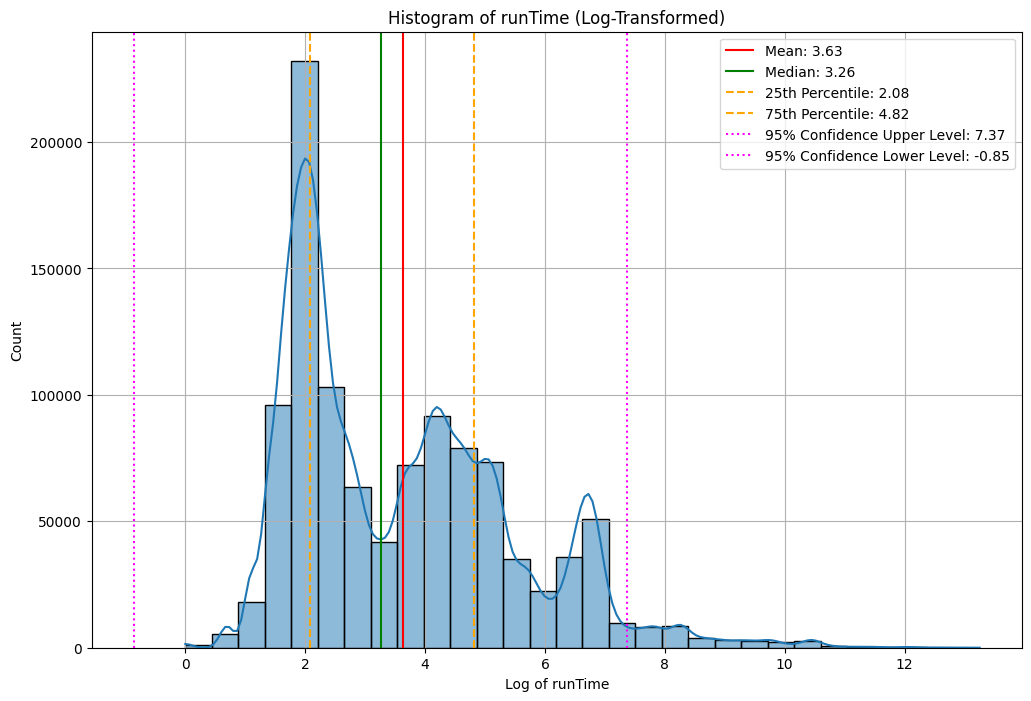

Generating scatter plots for variable of interest vs candidate covariates...


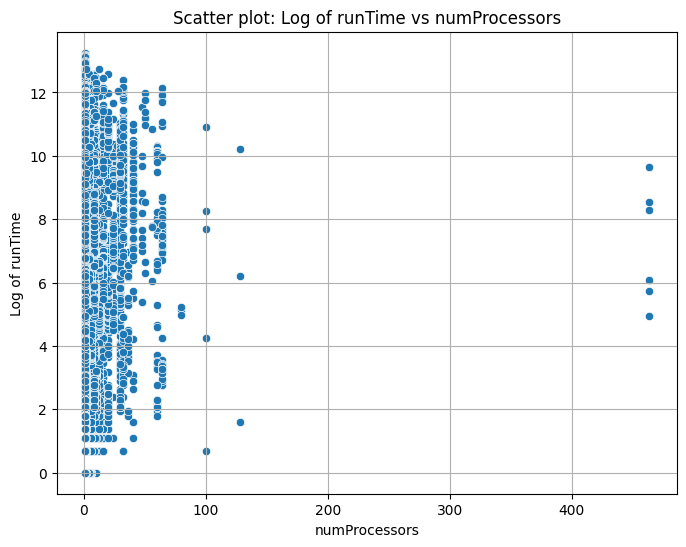

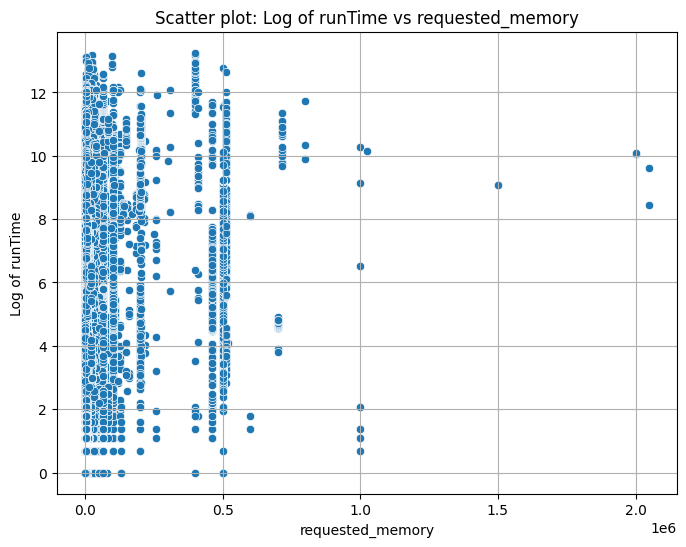

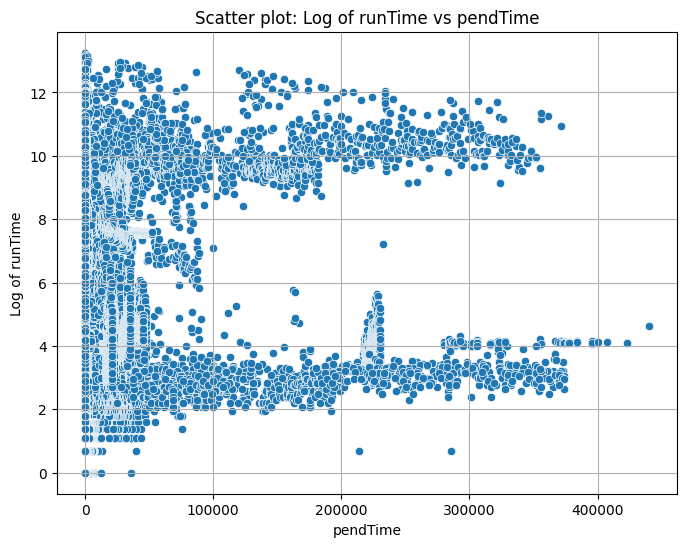

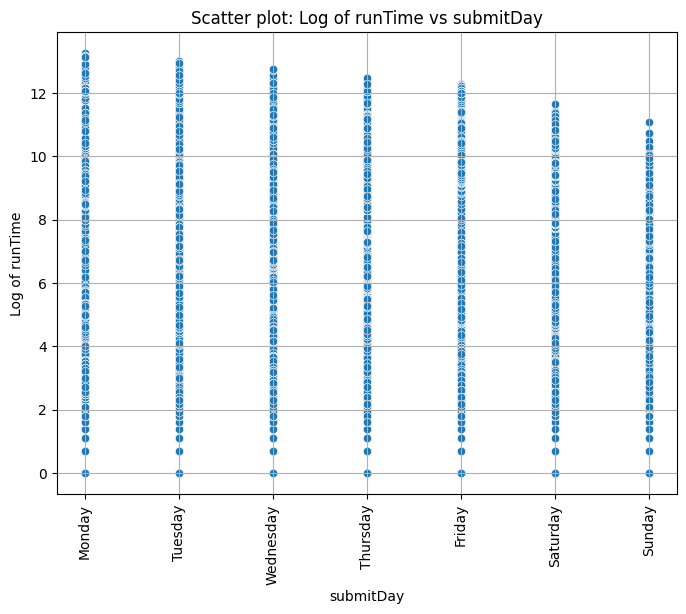

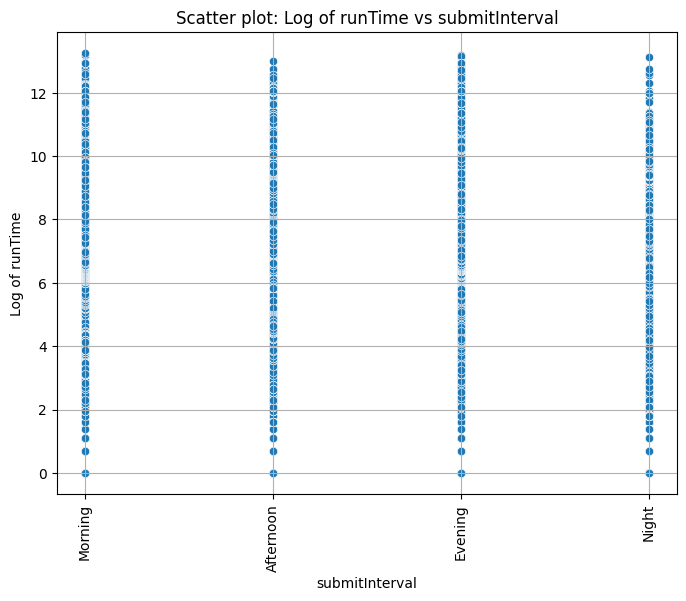

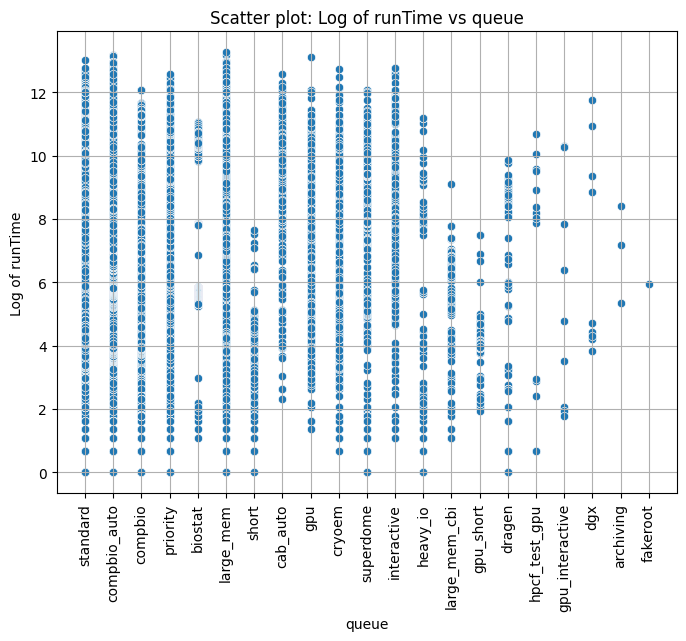

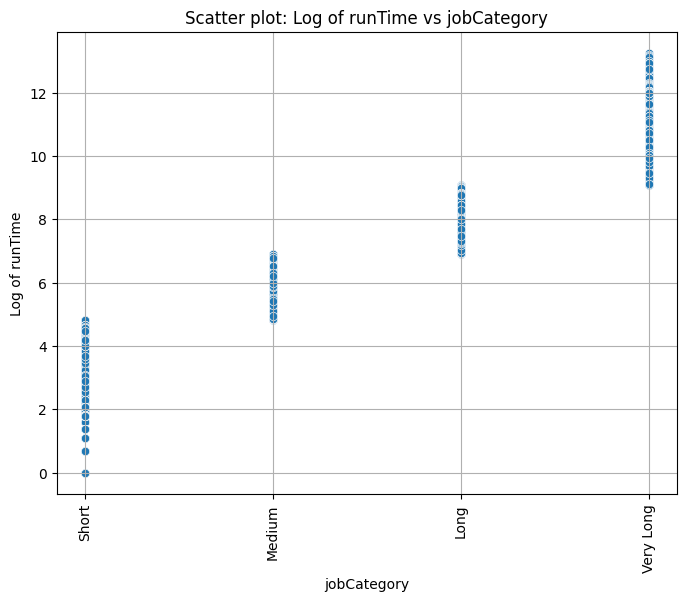

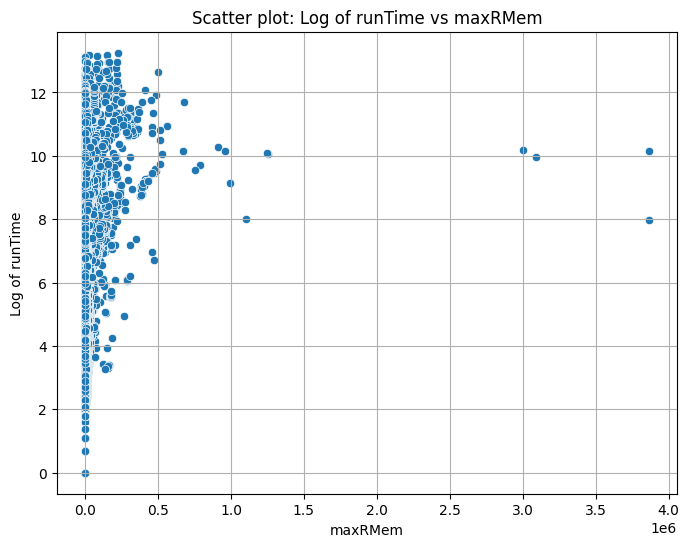

Calculating correlation matrix for variable of interest and candidate covariates...

Correlation matrix:
                   runTime  numProcessors  requested_memory  pendTime  \
runTime           1.000000       0.113585          0.163383  0.113078   
numProcessors     0.113585       1.000000          0.034511  0.023198   
requested_memory  0.163383       0.034511          1.000000  0.044386   
pendTime          0.113078       0.023198          0.044386  1.000000   
maxRMem           0.237835       0.174228          0.273838  0.135583   

                   maxRMem  
runTime           0.237835  
numProcessors     0.174228  
requested_memory  0.273838  
pendTime          0.135583  
maxRMem           1.000000  


/tmp/ipykernel_658247/2894395959.py:122: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_selected.corr()


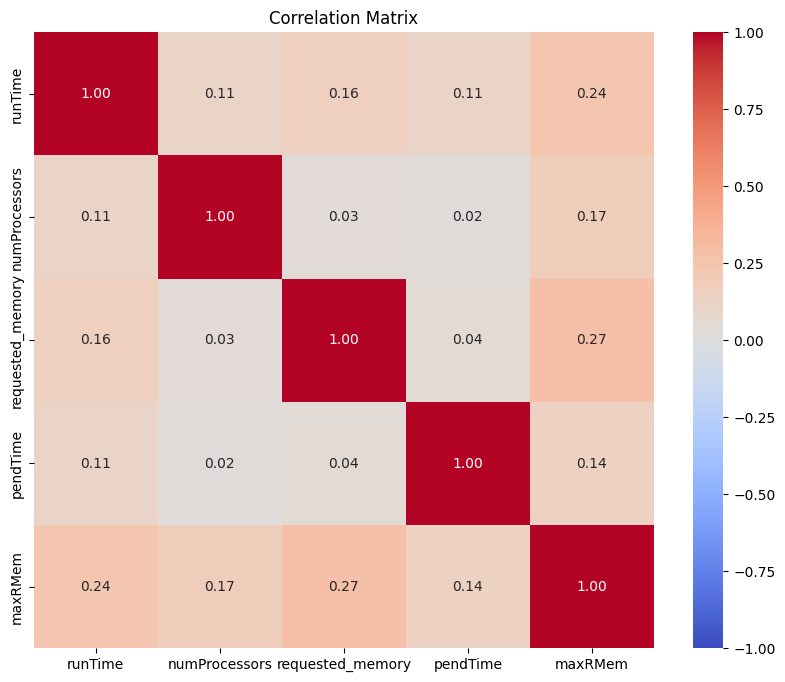

Fitting a model to predict the variable of interest...

Model fitting completed. Here are the model results:
                            OLS Regression Results                            
Dep. Variable:                runTime   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                 9.835e+04
Date:                Fri, 06 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:35:48   Log-Likelihood:            -1.4064e+06
No. Observations:             1065184   AIC:                         2.813e+06
Df Residuals:                 1065147   BIC:                         2.813e+06
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------

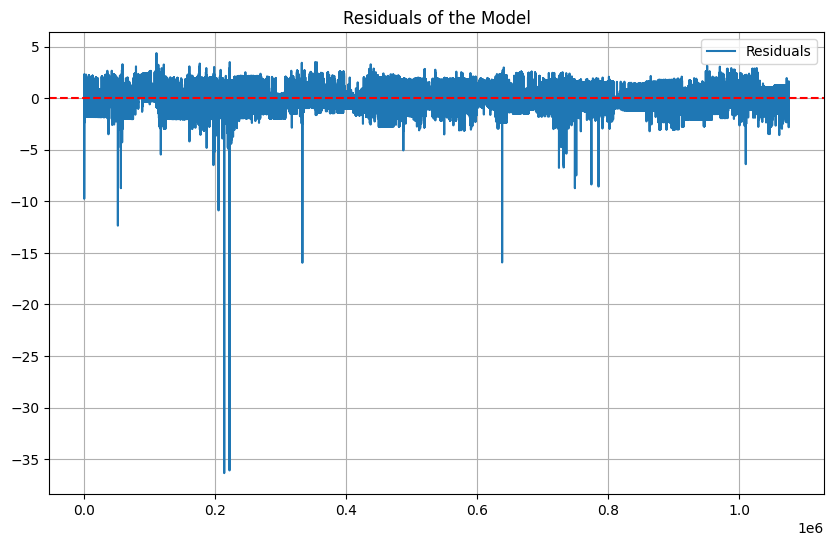


Report generation complete.


In [21]:
# Example usage
file_path = '../common/finished_jobs_1_week.csv'
df_preprocessed = modelProcess_csv(file_path)
generate_report(df=df_preprocessed, 
                startTime='2024-01-01', 
                endTime='2024-12-31', 
                variable_of_interest='runTime', 
                candidate_covariates=['numProcessors', 'requested_memory', 'pendTime', 'submitDay', 'submitInterval', 'queue', 'jobCategory', 'maxRMem'],
                log_scale=True)